In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import read_mist_models
import glob
from scipy.stats import norm

# (a) Photometry for M92

Photometric data from Hubble Space Telescope ACS Globular Cluster Survey- in the filters F606W (591nm) and F814W (833.3nm)

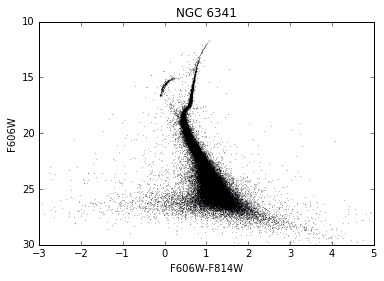

In [2]:
data = np.loadtxt('NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt',usecols=(3,7),skiprows=1).T

f,ax = plt.subplots()
ax.scatter((data[0]-data[1]),data[0],s=0.01)
ax.set_ylim(30,10)
ax.set_xlim(-3,5)
ax.set_xlabel(r'F606W-F814W')
ax.set_ylabel(r'F606W')
ax.set_title('NGC 6341')

The above CMD is dominated at the red-low magnitude end by binary stars in the main sequence which introduce scatter and 'weigh down' the fit of the isochrone. To avoid this and give more relative weightage to the turn-off and the red giant branch, I ignored data below a magnitude of ~20 (arbitrarily picked). I haven't explored if it would be possible to down weigh this part of the CMD without ignoring it altogether.

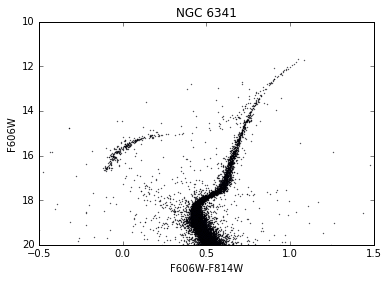

In [3]:
mask = np.where(data[0]<20)[0]
data_tofit = data[:,mask]
data = data_tofit

plt.scatter((data[0]-data[1]),data[0],s=0.1)
plt.ylim(20,10)
plt.xlim(-0.5,1.5)
plt.xlabel(r'F606W-F814W')
plt.ylabel(r'F606W')
plt.title('NGC 6341')

# Fitting MIST Isochrones

Synthetic Photometry data can be generated using MIST at different ages and metallicities. The resolution in metallicity in the Packaged Model Grids for the required HST filters (ACS_WFC_F606W and ACS_WFC_F814W) is much lower than what we want to fit for.

Using published literature, we know that M92 is an old (~14Gyr), metal poor (Fe/H ~ -2) cluster. To arrive at an age and metallicity for this cluster, it should be sufficient to iterate over values close to these predicted results. Hence, I only generated the isochrones for:
1. $-2.25 < Fe/H < -2.00$
2. $9.5< \log{age} < 10.3$ 

both with a resolution of 0.05 dex. I also used the prior knowledge that Av = 0.034 for the I-band (from NED) while generating the isochrones. 

In the following piece of code, I extracted the photometry data in the required two filters for the entire range of metallicities and ages, and put them into an accessible dictionary so I can running a fitting program on it.

In [4]:
isochrones = {}
i = 0

for files in np.sort(glob.glob('MIST_iso_*')):
    z = 2 + i*0.05
    i+=1
    isochrones[z] = {}
    iso = read_mist_models.ISOCMD(files)

    for age in iso.ages:
        isochrones[z][age] = np.vstack((iso.isocmds[iso.age_index(age)]['ACS_WFC_F606W'], 
                                        iso.isocmds[iso.age_index(age)]['ACS_WFC_F814W']))

Reading in: MIST_iso_m200.iso.cmd
Reading in: MIST_iso_m205.iso.cmd
Reading in: MIST_iso_m210.iso.cmd
Reading in: MIST_iso_m215.iso.cmd
Reading in: MIST_iso_m220.iso.cmd
Reading in: MIST_iso_m225.iso.cmd


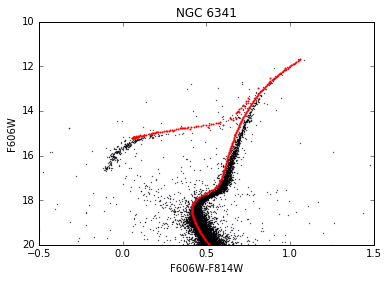

In [5]:
# For a random age, metallicity and distance plot the data and check if the extraction went as per expectation.

plt.scatter((data[0]-data[1]),data[0],s=0.1)
# c = isochrones[2.15][10.3][0] - isochrones[2.15][10.3][1]
# m = isochrones[2.15][10.3][1] -5 + 5*np.log10(8.2*1e3)

plt.scatter((isochrones[2.15][10.15][0] - isochrones[2.15][10.15][1]),
            (isochrones[2.15][10.15][0] -5 + 5*np.log10(8.2*1e3)),color='red',s=1.0)
plt.ylim(20,10)
plt.xlim(-0.5,1.5)
plt.xlabel(r'F606W-F814W')
plt.ylabel(r'F606W')
plt.title('NGC 6341')

Rather than using $\texttt{emcee}$ to fit for the age and metallicity, I decided to step through all the values. There are only 17 distinct $\log{age}$ values, 6 distinct $Fe/H$ values and 12 different ages, giving only 1224 unique combinations. Even with a 100 walkers and 10 steps (which might possible not be sufficient to converge), this is fewer steps than $\texttt{emcee}$ would take.

I adopted a strong prior on extinction-- I did not fit for extinction explicity assuming that the MIST Isochrones that were generated with $A_v = 0.034$ accounted for this effect sufficiently.

Summarizing, my priors are as follows:

1. -2.25 < [Fe/H] < -2.00
2. 9.5< $\log{age}$ < 10.3 
3. 8 < Distance (in kpc) < 11
4. $A_v = 0.034$

where the ranges are varied in discreet intervals of 0.05 dex.

In [6]:
color = data[0]-data[1]
mag = data[0]

z = list(isochrones.keys())
z = np.sort(z)
age = iso.ages
D = np.arange(8,11,0.25)

lsq = np.zeros([np.size(z),np.size(age),np.size(D)])

for i,met in enumerate(z):
    for j,ages in enumerate(age):
        c = isochrones[met][ages][0] - isochrones[met][ages][1]
        for k,dist in enumerate(D):
            m = np.copy(isochrones[met][ages][0])
            m += -5 + 5*np.log10(dist*1e3)
            
            mask = np.where(m < 20)
            mfil = m[mask]
            cfil = c[mask]
   
            ls = 0
            for l,x in enumerate(cfil):
                ls+= ((color-x)**2 + (mag-mfil[l])**2).min()
                
            lsq[i][j][k] = ls

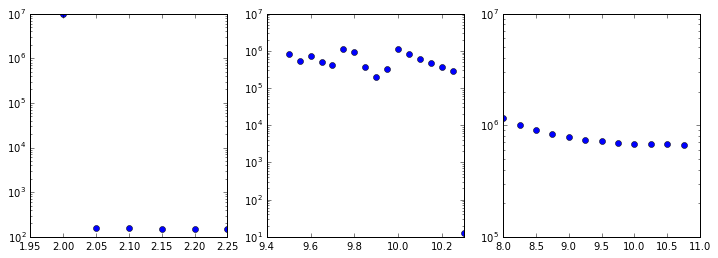

In [7]:
f1,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.semilogy(z,[np.sum(np.square(lsq[i])) for i,met in enumerate(z)],'o')
ax2.semilogy(age,[np.sum(np.square(lsq[:,i,:])) for i in range(np.size(age))],'o')
ax3.semilogy(D,[np.sum(np.square(lsq[:,:,i])) for i in range(np.size(D))],'o')

# MIST Isochrone fitting - Results

Through an iterative fitting process, the best fit values are:

1. Metallicity [Fe/H] = -2.25
2. $\log (age)$ = 10.15; Age = 14.12 Gyr
3. Distance = 9kpc

In the plot below, the best fit isochrone does not pass through the center of the MS. This is possibly because I predetermined the extinction and did not fit separately for either that or the extinction.

In [8]:
idx = np.where(lsq == np.min(lsq))
z_final = z[idx[0][0]]
age_final = age[idx[1][0]]
dist_final = D[idx[2][0]]
print (z_final,age_final,dist_final)

(2.25, 10.15, 9.0)


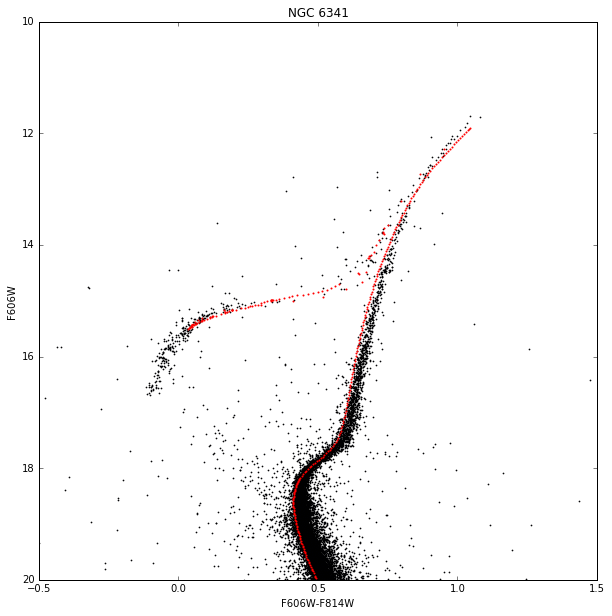

In [9]:
f2,ax2 = plt.subplots(figsize=(10,10))

c = isochrones[z_final][age_final][0]-isochrones[z_final][age_final][1]
m = isochrones[z_final][age_final][0] -5 + 5*np.log10(dist_final*1e3)
mask = np.where(m < 20)
mfil = m[mask]
cfil = c[mask]

ax2.scatter((data[0]-data[1]),data[0],s=0.5)
ax2.scatter(cfil,mfil,color='red',s=1.0)
ax2.set_ylim(20,10)
ax2.set_xlim(-0.5,1.5)
ax2.set_xlabel(r'F606W-F814W')
ax2.set_ylabel(r'F606W')
ax2.set_title('NGC 6341')

# PARSEC Isochrone fitting

Next, I repeated the same procedure with PARSEC isochrone models. The PARSEC models did not go to very low metallicities- the lowest metallicity was $Z\sim 0.0001$ which came to [Fe/H] $\sim -2.20$. The maximum age was also only 10.1 in log space. Within this limited range of values, I generated isochrones for varying metallicity and age much like the MIST models. I ran the same fitter on this set of data.

In [10]:
fe_h = np.arange(-2.25,-1.99,0.05)
z_sun = 0.0152
Z = z_sun*(10**fe_h)
print (Z)

[  8.54758814e-05   9.59055164e-05   1.07607759e-04   1.20737892e-04
   1.35470143e-04   1.52000000e-04]


In [11]:
parsec_isos = {}
i = 0

for files in np.sort(glob.glob('PARSEC_iso_kroupa_*')):
    z = 2 + i*0.05
    i+=1
    parsec_isos[z] = {}
    iso = np.loadtxt(files,usecols=(1,13,18)).T
    ages = np.unique(np.around(iso[0],decimals=2))
    
    for x,age in enumerate(ages):
        mask = np.where(iso[0]==age)
        parsec_isos[z][age] = np.vstack((iso[1][mask],iso[2][mask]))

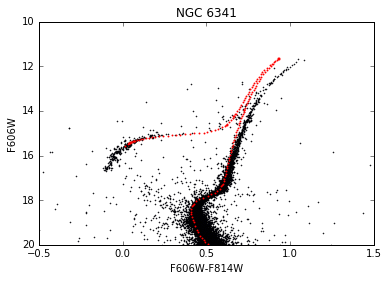

In [12]:
plt.scatter((data[0]-data[1]),data[0],s=0.3)
plt.scatter((parsec_isos[2.2][10.1][0] - parsec_isos[2.2][10.1][1]),
            (parsec_isos[2.2][10.1][0] -5 + 5*np.log10(9*1e3)),color='red',s=0.8)
plt.ylim(20,10)
plt.xlim(-0.5,1.5)
plt.xlabel(r'F606W-F814W')
plt.ylabel(r'F606W')
plt.title('NGC 6341')

In [13]:
color = data[0]-data[1]
mag = data[0]

z = list(parsec_isos.keys())
np.sort(z)
age = list(parsec_isos[2.15].keys())
np.sort(age)
D = np.arange(8,11,0.25)

lsq = np.zeros([np.size(z),np.size(age),np.size(D)])
print (np.shape(lsq))

for i,met in enumerate(z):
    for j,ages in enumerate(age):
        c = parsec_isos[met][ages][0] - parsec_isos[met][ages][1]
        for k,dist in enumerate(D):
            m = np.copy(parsec_isos[met][ages][0])
            m += -5 + 5*np.log10(dist*1e3) + 0.034
## Fit only the turn off of the MS and see if the fit is any better.             
            mask = np.where((m < 20) & (m>17))
            mfil = m[mask]
            cfil = c[mask]
            
            ls = 0
            for l,x in enumerate(cfil):
                ls+= ((color-x)**2 + (mag-mfil[l])**2).min()
                
            lsq[i][j][k] = ls

(5, 13, 12)


# PARSEC Isochrone Fitting -- Results

While fitting the PARSEC isochrones, I initially tried fitting all the data with a magnitude larger than 20 (like I did for the MIST models to avoid weighing down by binaries), but there is significant discrepancy in observations and the theoretical PARSEC models for the red-giant branch. I checked if this discrepancy could have been due to using a different IMF but found that the Kroupa IMF gave the same results as the Chabrier (nearly).

The reddening of the red giant branch in observations is possibly due to galactic extinction, which I did not fit for or include in the isochrones that I generated. Adding a reddening factor of $\sim 0.01$ by hand did decrease the discrepancy in the red giant branch but it also changed the MS fit. I am not sure where the large differences in this part of the CMD come from, in the PARSEC models, or how to account for it.

In order to avoid the red giant branch from influencing the age estimation (result: $\sim 7Gyr$), I re-ran the fitting algorithm on only the MS turn off part of the CMD. This resulted in a better age estimate. The final results of this fit, without any kind of correction for extinction, are:

1. Metallicity [Fe/H] = -2
2. Distance = 9 kpc
3. Age = 12.6 Gyr

In [14]:
idx = np.where(lsq == np.min(lsq))
z_final = z[idx[0][0]]
age_final = age[idx[1][0]]
dist_final = D[idx[2][0]]
print (z_final,age_final,dist_final)

(2.0, 10.1, 9.0)


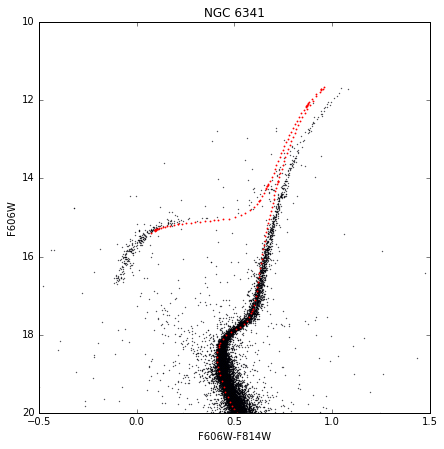

In [17]:
f3,ax3 = plt.subplots(figsize=(7,7))

c = parsec_isos[z_final][age_final][0]-parsec_isos[z_final][age_final][1]
m = parsec_isos[z_final][age_final][0] -5 + 5*np.log10(dist_final*1e3)
mask = np.where(m < 20)
mfil = m[mask]
cfil = c[mask]

ax3.scatter((data[0]-data[1]),data[0],s=0.1)
ax3.scatter(cfil,mfil,color='red',s=0.7)
ax3.set_ylim(20,10)
ax3.set_xlim(-0.5,1.5)
ax3.set_xlabel(r'F606W-F814W')
ax3.set_ylabel(r'F606W')
ax3.set_title('NGC 6341')

# (d) Comparision

The PARSEC and MIST isochrone best fit results do not differ significantly from each other in the final results, even though their best fit plots appear entirely different.

| Property |MIST | PARSEC | Literature |
|----------|:-----:|:------:|:------------:|
|[Fe/H]| -2.25 | -2.00 | -2.16 |
| Age (in Gyr) | 14.12 | 12.6 | 14.2 |
| Distance (kpc) | 9 | 9| 8.2|

The discrepancy in age between MIST and PARSEC seems to be a lot, but while fitting in the log space the difference between the two values is only 0.1 dex. Despite this, the MIST value comes very close to the published results (without computing errors on these parameters it will be difficult to say how accurately close).

### Source of Errors

1. Extinction: While fitting the MIST models I fixed the extinction in the I-band to 0.034 and did not fit for this, which could have introduced the error in the MS part of the fit. For the PARSEC models I did not consider extinction at all which could have been a major source of error! It is possibly the reason why the red giant branch of the best fit is completely off the observed CMD.

2. Low metallicity: PARSEC did not give the flexibility of decreasing the metallicity below [Fe/H]=-2, which is higher than the published result. We know a higher metallicity increases the color (reddens the CMD), so this could have been another reason for the mismatch in the RG branch and also a source of error in age estimation.

3. Age: PARSEC was again too picky about large ages, not allowing one to generate isochrones for ages larger than the current estimated age of the universe. While this is reasonable, the extreme reddening of the cluster would have introduced an error in the fit due to lack of this data.

4. Quantised parameters: All the parameters that I fit for were varied in quantized intervals of 0.05 dex which I am sure introduced a significant error to the best fits of both MIST and PARSEC. That said, I do not know if the errors on the observational data even allow for a greater resolution of these parameters.